['embedding_outputs', 'hdbscan_labels', 'ground_truth_labels', 'predictions', 's', 'hdbscan_colors', 'ground_truth_colors', 'original_spectogram', 'vocalization', 'file_indices', 'dataset_indices', 'file_map']
Loaded 50,000×2


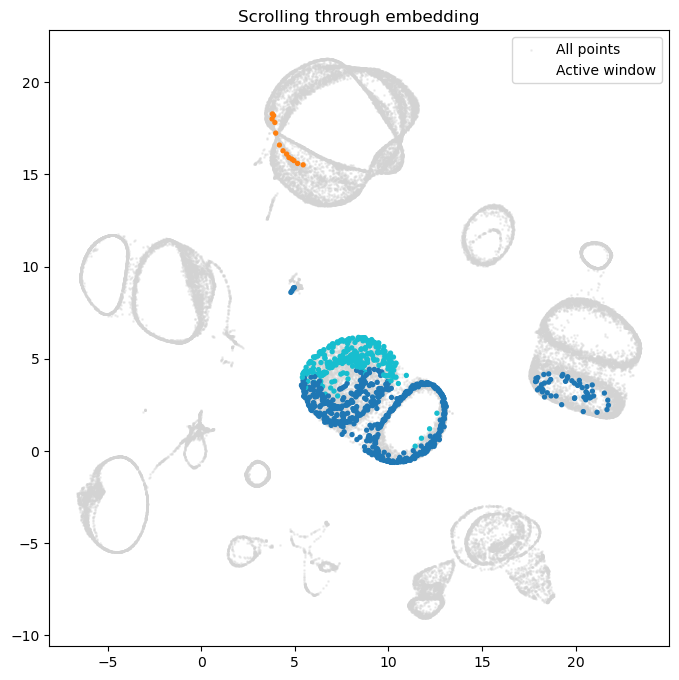

In [2]:
import numpy as np
import matplotlib.pyplot as plt
arr   = np.load("/home/george-vengrovski/Documents/projects/tweety_bert_paper/files/llb16_raw_false.npz")
print(arr.files)
X_np  = arr["embedding_outputs"].astype(np.float32)[:50_000]   # slice for demo
y_np  = arr["ground_truth_labels"][:50_000]
N, D  = X_np.shape
print(f"Loaded {N:,}×{D}")
# Visualization parameters
window_size = 1000
step = 100
interval = 30  # ms between frames

# Pick two dimensions for visualization (e.g., first two)
x = X_np[:, 0]
y = X_np[:, 1]
labels = y_np
# Set up the plot
fig, ax = plt.subplots(figsize=(8, 8))
scat_dim = ax.scatter(x, y, c='lightgray', s=1, alpha=0.3, label='All points')
scat_highlight = ax.scatter([], [], c=[], s=8, cmap='tab10', vmin=labels.min(), vmax=labels.max(), label='Active window')
ax.set_title('Scrolling through embedding')
ax.legend()
# Animation update function
def update(frame):
    start = frame * step
    end = min(start + window_size, N)
    x_win = x[start:end]
    y_win = y[start:end]
    labels_win = labels[start:end]
    scat_highlight.set_offsets(np.c_[x_win, y_win])
    scat_highlight.set_array(labels_win)
    return scat_highlight,
num_frames = (N - window_size) // step
from matplotlib.animation import FuncAnimation
ani = FuncAnimation(fig, update, frames=num_frames, interval=interval, blit=True, repeat=True)
# To save as GIF, uncomment the following lines:
ani.save('embedding_scroll.gif', writer='pillow', fps=1000//interval)
plt.show()
